In [10]:
# # !pip install opencv-python
# # !python.exe -m pip install --upgrade pip
# !pip install tensorflow
# !pip install keras
# # pip install numpy
# !pip install pandas
# # pip install scikit-learn
# # pip install matplotlib
# # pip install pillow
# # pip install requests
# # pip install fastapi
# # pip install uvicorn[standard]
# # pip install joblib

  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.2 MB/s eta 0:04:36
   ---------------------------------------- 1.3/332.0 MB 1.8 MB/s eta 0:03:06
   ---------------------------------------- 1.3/332.0 MB 1.8 MB/s eta 0:03:06
   ---------------------------------------- 2.1/332.0 MB 2

# 3. Part A: Data Preprocessing and Exploration
## 3.1 Task A.1: Load and Explore Image Data
### Goal: Load the UTKFace dataset, parse filenames for labels, and visualize sample images.

Loading UTKFace dataset...
Total images found: 5000
Processed 5000 images...

--- Dataset Loading Complete ---
Successfully loaded: 5000 images
Skipped (corrupted/invalid): 0 images

--- Dataset Statistics ---
Images shape: (5000, 64, 64, 3)
Labels shape: (5000,)
Gender distribution: [2094 2906]
Male (0): 2094 images
Female (1): 2906 images
Image dtype: uint8
Pixel value range: [0, 255]

Sample images visualization saved as 'sample_images.png'


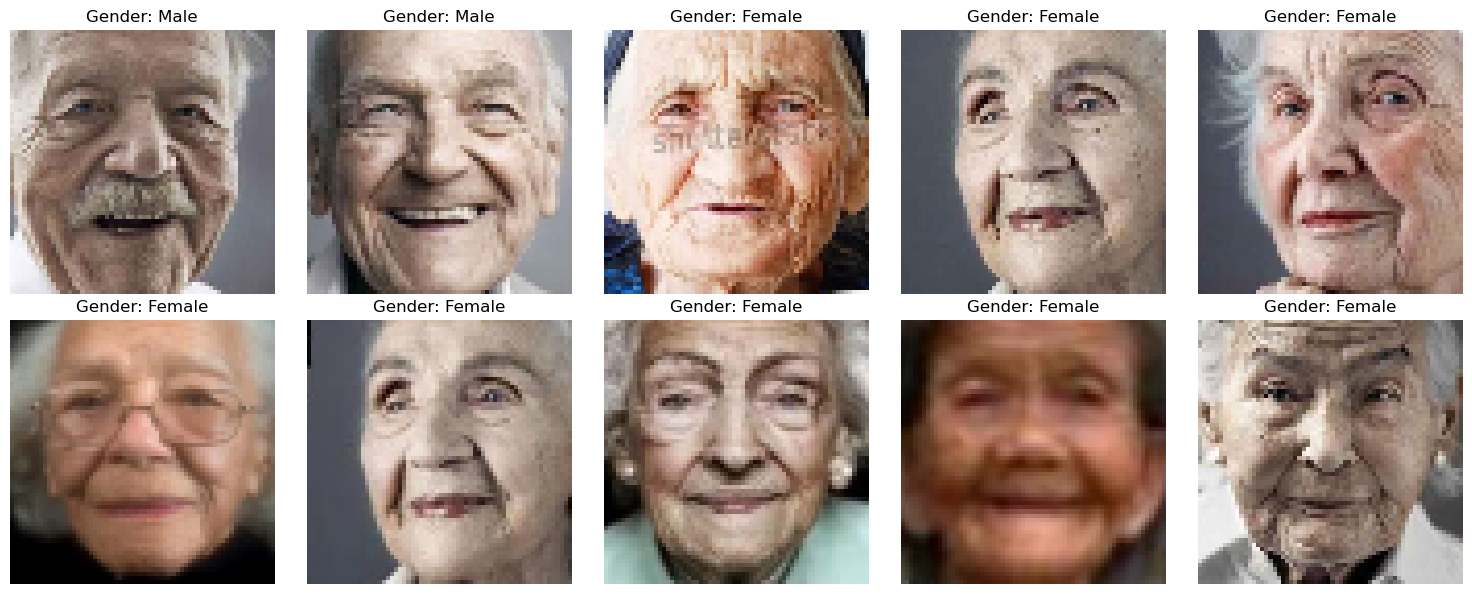

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = 'data/utkface'
IMG_SIZE = 64  # Resize all images to 64x64
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# 1. Parse filenames and extract labels
def load_dataset(data_dir, img_size=64, max_samples=None):
    """
    Load images and extract labels from filenames.
    Filename format: [age]_[gender]_[race]_[date&time].jpg
    Gender: 0=Male, 1=Female
    """
    images = []
    labels = []
    skipped = 0
    
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    
    if max_samples:
        image_files = image_files[:max_samples]
    
    print(f"Total images found: {len(image_files)}")
    
    for idx, filename in enumerate(image_files):
        try:
            # Parse filename
            parts = filename.split('_')
            if len(parts) < 3:
                skipped += 1
                continue
            
            age = int(parts[0])
            gender = int(parts[1])  # 0=Male, 1=Female
            
            # Load and preprocess image
            img_path = os.path.join(data_dir, filename)
            img = cv2.imread(img_path)
            
            if img is None:
                skipped += 1
                continue
            
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize to fixed size
            img = cv2.resize(img, (img_size, img_size))
            
            images.append(img)
            labels.append(gender)
            
            if (idx + 1) % 5000 == 0:
                print(f"Processed {idx + 1} images...")
                
        except Exception as e:
            skipped += 1
            continue
    
    print(f"\n--- Dataset Loading Complete ---")
    print(f"Successfully loaded: {len(images)} images")
    print(f"Skipped (corrupted/invalid): {skipped} images")
    
    return np.array(images), np.array(labels)

# 2. Load the dataset (using max_samples for faster iteration)
# For full training, remove max_samples or set to None
print("Loading UTKFace dataset...")
X, y = load_dataset(DATA_DIR, img_size=IMG_SIZE, max_samples=5000)

# 3. Analyze dataset
print(f"\n--- Dataset Statistics ---")
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Gender distribution: {np.bincount(y)}")
print(f"Male (0): {np.sum(y == 0)} images")
print(f"Female (1): {np.sum(y == 1)} images")
print(f"Image dtype: {X.dtype}")
print(f"Pixel value range: [{X.min()}, {X.max()}]")

# 4. Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx in range(10):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    ax.imshow(X[idx])
    gender_label = "Female" if y[idx] == 1 else "Male"
    ax.set_title(f"Gender: {gender_label}")
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=100, bbox_inches='tight')
print("\nSample images visualization saved as 'sample_images.png'")
plt.show()

# 3.2 Task A.2: Normalize and Split Data
### Goal: Normalize pixel values and split data into training, validation, and test sets.

In [8]:
from sklearn.model_selection import train_test_split

# 1. Normalize pixel values to [0, 1]
print("Normalizing pixel values...")
X_normalized = X.astype('float32') / 255.0
print(f"Normalized pixel range: [{X_normalized.min()}, {X_normalized.max()}]")

# 2. Split into train, validation, test
print("\nSplitting dataset...")
# First split: separate test set (10% of total)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y, test_size=TEST_SPLIT, random_state=42, stratify=y
)

# Second split: separate validation from training (20% of remaining = ~18% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# 3. Verify class balance in splits
print(f"\nClass distribution in training set:")
print(f"  Male: {np.sum(y_train == 0)}, Female: {np.sum(y_train == 1)}")
print(f"Class distribution in validation set:")
print(f"  Male: {np.sum(y_val == 0)}, Female: {np.sum(y_val == 1)}")
print(f"Class distribution in test set:")
print(f"  Male: {np.sum(y_test == 0)}, Female: {np.sum(y_test == 1)}")

Normalizing pixel values...
Normalized pixel range: [0.0, 1.0]

Splitting dataset...
Training set: (3600, 64, 64, 3)
Validation set: (900, 64, 64, 3)
Test set: (500, 64, 64, 3)

Class distribution in training set:
  Male: 1508, Female: 2092
Class distribution in validation set:
  Male: 377, Female: 523
Class distribution in test set:
  Male: 209, Female: 291


# 4. Part B: Building and Training a Deep Neural Network
## 4.1 Task B.1: Design and Train a CNN Model
### Goal: Flatten images into 1D vectors and build a fully connected neural network with multiple hidden layers.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Flatten the training, validation, and test data
print("Flattening image data for fully connected network...")
# Reshape images from (N, 64, 64, 3) to (N, 12288)
# because 64 * 64 * 3 = 12,288 input features
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

print(f"Original shape: {X_train.shape}")
print(f"Flattened shape: {X_train_flattened.shape}")
print(f"Total input features: {X_train_flattened.shape[1]}")

# 2. Create a Fully Connected Neural Network
print("\nBuilding Fully Connected Neural Network...")

input_dim = X_train_flattened.shape[1]  # 12,288 features

model = models.Sequential([
    # Input layer implicit in first Dense layer
    # Hidden Layer 1 - 1024 neurons
    layers.Dense(1024, activation='relu', input_dim=input_dim),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Hidden Layer 2 - 512 neurons
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Hidden Layer 3 - 256 neurons
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Hidden Layer 4 - 128 neurons
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Hidden Layer 5 - 64 neurons
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output layer (binary classification)
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile the model
print("\nCompiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# 4. Display model architecture
print("\n--- Model Architecture ---")
model.summary()

# Calculate number of parameters in first Dense layer
print(f"\n--- Parameter Analysis ---")
print(f"Input features: {input_dim}")
print(f"First hidden layer neurons: 1024")
print(f"Parameters in first layer (weights): {input_dim * 1024} + 1024 (bias) = {input_dim * 1024 + 1024}")

# 5. Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'models/best_gender_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# 6. Train the model on flattened data
print("\n--- Starting Training ---")
history = model.fit(
    X_train_flattened, y_train,
    batch_size=BATCH_SIZE,
    epochs=2,
    validation_data=(X_val_flattened, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n--- Training Complete ---")

Flattening image data for fully connected network...
Original shape: (3600, 64, 64, 3)
Flattened shape: (3600, 12288)
Total input features: 12288

Building Fully Connected Neural Network...

Compiling model...

--- Model Architecture ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 1024)                │      12,583,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,289,217 (50.69 MB)

 Trainable params: 13,285,249 (50.68 MB)

 Non-trainable params: 3,968 (15.50 KB)


--- Parameter Analysis ---
Input features: 12288
First hidden layer neurons: 1024
Parameters in first layer (weights): 12582912 + 1024 (bias) = 12583936

--- Starting Training ---
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5766 - loss: 0.7893 - precision: 0.6587 - recall: 0.5776
Epoch 1: val_accuracy improved from None to 0.60556, saving model to models/best_gender_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.6031 - loss: 0.7313 - precision: 0.6720 - recall: 0.6190 - val_accuracy: 0.6056 - val_loss: 0.7086 - val_precision: 0.6129 - val_recall: 0.8719 - learning_rate: 0.0010
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6468 - loss: 0.6303 - precision: 0.7002 - recall: 0.6733
Epoch 2: val_accuracy improved from 0.60556 to 0.68889, saving model to models/best_gender_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.6506 - loss: 0.6241 - precision: 0.7079 - recall: 0.6788 - val_accuracy: 0.6889 - val_loss: 0.5696 - val_precision: 0.7106 - val_recall: 0.7839 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.

--- Training Complete ---


# 4.2 Task B.2: Evaluate Model Performance
### Goal: Evaluate the trained model on the test set and visualize training history.

Evaluating model on test set...

--- Test Set Performance ---
Loss: 0.6137
Accuracy: 0.6560
Precision: 0.6787
Recall: 0.7766

Generating predictions on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 

--- Detailed Classification Report ---
              precision    recall  f1-score   support

        Male       0.61      0.49      0.54       209
      Female       0.68      0.78      0.72       291

    accuracy                           0.66       500
   macro avg       0.64      0.63      0.63       500
weighted avg       0.65      0.66      0.65       500


Confusion Matrix:
[[102 107]
 [ 65 226]]

Evaluation plots saved as 'evaluation_metrics.png'


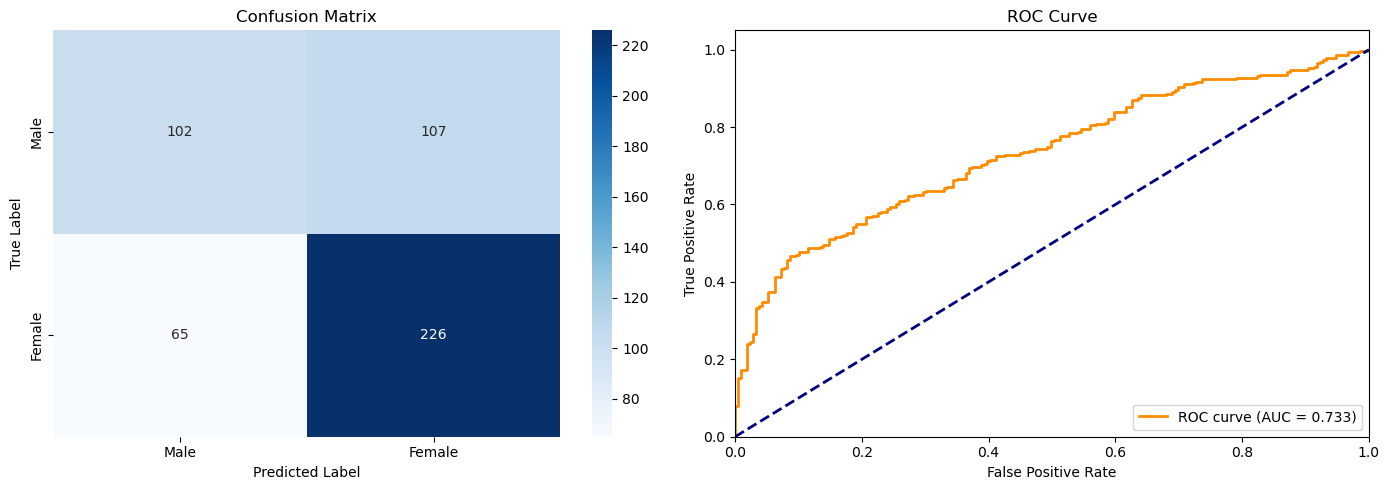

Training history plots saved as 'training_history.png'


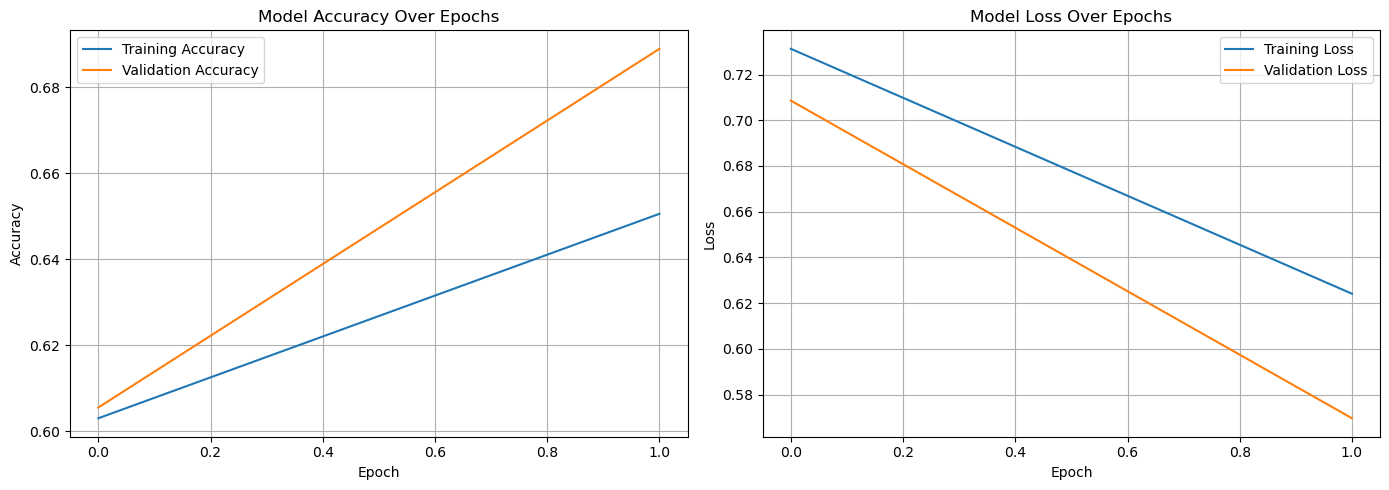

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_flattened, y_test, verbose=0
)

print(f"\n--- Test Set Performance ---")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# 2. Get predictions
print("\nGenerating predictions on test set...")
y_pred_proba = model.predict(X_test_flattened)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# 3. Detailed classification metrics
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Male', 'Female']))

# 4. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# 5. Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Male', 'Female'],
            yticklabels=['Male', 'Female'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=100, bbox_inches='tight')
print("\nEvaluation plots saved as 'evaluation_metrics.png'")
plt.show()

# 6. Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
print("Training history plots saved as 'training_history.png'")
plt.show()

# 5. Part C: Model Persistence and Deployment
## 5.1 Task C.1: Save and Load the Trained Model
### Goal: Persist the trained model and create utility functions for loading and inference.

In [15]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras

# --- Assumptions / variables you must have defined earlier in your script ---
# model               -> trained Keras model (expects flattened input if trained that way)
# IMG_SIZE            -> integer, e.g. 128
# X_train, X_val, X_test, X_test_flattened, y_test -> datasets used earlier
# test_accuracy, test_precision, test_recall -> metrics computed earlier

# Example placeholders (uncomment / replace with real values)
# IMG_SIZE = 128
# model = ...          # your trained model
# X_train, X_val, X_test = ...
# X_test_flattened = ... # flattened test images if you trained on flattened inputs
# y_test = ...

os.makedirs('models', exist_ok=True)

print("Saving trained model...")

# 1) Save as H5 (classic) — fine for later loading in Python
h5_path = 'models/gender_classifier_model.h5'
model.save(h5_path)
print(f"✓ Saved as H5 format: {h5_path}")

# 2) Save as SavedModel directory (for TF Serving / TFLite conversion)
# In Keras 3 use model.export(...) to create a TensorFlow SavedModel directory
saved_model_dir = 'models/gender_classifier_savedmodel'
# remove existing folder if you want to overwrite (optional)
if os.path.exists(saved_model_dir):
    import shutil
    shutil.rmtree(saved_model_dir)
model.export(saved_model_dir)
print(f"✓ Exported SavedModel directory: {saved_model_dir}")

# (Alternative) Save in native Keras single-file format:
# model.save('models/gender_classifier.keras')
# print("✓ Saved as .keras single-file format")

# 3) Save metadata (ensure values are JSON-serializable)
input_shape = [IMG_SIZE, IMG_SIZE, 3]
flattened_features = int(np.prod(input_shape))  # compute dynamically

metadata = {
    'model_name': 'Gender Classifier Fully Connected Network',
    'input_shape': input_shape,
    'flattened_input_features': flattened_features,
    'output_classes': ['Male', 'Female'],
    'normalization': 'pixel values divided by 255.0',
    'test_accuracy': float(test_accuracy) if 'test_accuracy' in globals() else None,
    'test_precision': float(test_precision) if 'test_precision' in globals() else None,
    'test_recall': float(test_recall) if 'test_recall' in globals() else None,
    'training_samples': int(len(X_train)) if 'X_train' in globals() else None,
    'validation_samples': int(len(X_val)) if 'X_val' in globals() else None,
    'test_samples': int(len(X_test)) if 'X_test' in globals() else None
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("✓ Saved metadata: models/model_metadata.json")

# 4) Load and verify the model (load from H5 for quick test)
print("\n--- Loading H5 model ---")
loaded_model = keras.models.load_model(h5_path)
print("✓ Model successfully loaded")
print(f"Model input shape: {loaded_model.input_shape}")
print(f"Model output shape: {loaded_model.output_shape}")

# 5) Verify predictions are identical (use same input preprocessing)
print("\nVerifying prediction consistency...")

# Prepare a sample. Use X_test_flattened if your model expects flattened vectors;
# otherwise use X_test with shape (H,W,3) if model expects images.
if 'X_test_flattened' in globals():
    sample_idx = np.random.randint(0, len(X_test_flattened))
    sample_image = X_test_flattened[sample_idx:sample_idx+1]  # shape (1, flattened_features)
else:
    # fallback if you only have image arrays
    sample_idx = np.random.randint(0, len(X_test))
    # make sure to normalize / flatten the same way used in training
    sample_image = X_test[sample_idx:sample_idx+1]
    sample_image = sample_image.reshape((1, -1)) if loaded_model.input_shape[-1] == flattened_features else sample_image

original_pred = model.predict(sample_image, verbose=0)
loaded_pred = loaded_model.predict(sample_image, verbose=0)

print(f"Original model prediction (first element): {original_pred.flatten()[0]:.6f}")
print(f"Loaded model prediction (first element): {loaded_pred.flatten()[0]:.6f}")
print(f"Predictions match (allclose): {np.allclose(original_pred, loaded_pred)}")

# 6) Inference helper (robustified)
def predict_gender(image_path, model=loaded_model, img_size=IMG_SIZE):
    """
    Predict gender from an image file.

    Returns:
        dict with 'gender', 'confidence', 'raw_prediction' or 'error'
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            return {'error': f'Could not load image: {image_path}'}
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0

        # Determine what model expects (flattened vs image)
        expected_shape = model.input_shape  # (None, N) or (None, H, W, C)
        if len(expected_shape) == 2:
            # flattened vector expected (None, features)
            img_flat = img.flatten().astype('float32')
            if img_flat.size != expected_shape[1]:
                return {'error': f'Flattened size mismatch: expected {expected_shape[1]}, got {img_flat.size}'}
            inp = np.expand_dims(img_flat, axis=0)
        else:
            # image tensor expected (None, H, W, C)
            inp = np.expand_dims(img, axis=0)

        pred = model.predict(inp, verbose=0)[0]
        # For two-class softmax output, choose index; if single-output sigmoid, interpret differently
        if pred.size == 1:
            raw = float(pred[0])
            gender = 'Female' if raw > 0.5 else 'Male'
            confidence = raw if raw > 0.5 else (1 - raw)
        else:
            # multi-class softmax
            idx = int(np.argmax(pred))
            raw = float(pred[idx])
            gender = ['Male', 'Female'][idx] if len(pred) == 2 else f'class_{idx}'
            confidence = raw

        return {'gender': gender, 'confidence': float(confidence), 'raw_prediction': float(raw)}

    except Exception as e:
        return {'error': str(e)}

# 7) Test the inference function using a sample from X_test
print("\n--- Testing Inference Function ---")
test_image_idx = 0
# If X_test contains normalized floats, convert back to uint8 for writing a test file
test_image_array = (X_test[test_image_idx] * 255).astype(np.uint8) if X_test.dtype != np.uint8 else X_test[test_image_idx]
test_image_path = 'test_image_sample.jpg'
cv2.imwrite(test_image_path, cv2.cvtColor(test_image_array, cv2.COLOR_RGB2BGR))

result = predict_gender(test_image_path)
actual_gender = 'Female' if int(y_test[test_image_idx]) == 1 else 'Male'
if 'error' in result:
    print("Inference error:", result['error'])
else:
    print(f"Predicted: {result['gender']} (confidence: {result['confidence']:.4f})")
    print(f"Actual: {actual_gender}")


Saving trained model...
✓ Saved as H5 format: models/gender_classifier_model.h5
INFO:tensorflow:Assets written to: models/gender_classifier_savedmodel\assets


INFO:tensorflow:Assets written to: models/gender_classifier_savedmodel\assets


Saved artifact at 'models/gender_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12288), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1252308427088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308428240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308427856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308427664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308427280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308428048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308428432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308429392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308429008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308428816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1252308426704: Ten

✓ Model successfully loaded
Model input shape: (None, 12288)
Model output shape: (None, 1)

Verifying prediction consistency...
Original model prediction (first element): 0.581339
Loaded model prediction (first element): 0.581339
Predictions match (allclose): True

--- Testing Inference Function ---
Predicted: Female (confidence: 0.8185)
Actual: Male
